## Data Cleaning

In [545]:
import pandas as pd
import numpy as np
import regex as re
import seaborn as sns
from datetime import datetime
from scipy.interpolate import LSQUnivariateSpline
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from scipy.stats import norm, lognorm

# read excel file
df = pd.read_excel('C1Data.xlsx', sheet_name=None)

# name the sheets
bonds = df['Bonds']
yield_curve = df['YieldCurve']
rating = df['RatingDFRate2024']

# change columns to datetime
bonds['OFFERING_DATE'] = pd.to_datetime(bonds['OFFERING_DATE'])
bonds['MATURITY'] = pd.to_datetime(bonds['MATURITY'])
bonds['TRD_EXCTN_DT'] = pd.to_datetime(bonds['TRD_EXCTN_DT'])

#find the ones where the trade date is after the maturity date and remove them
bonds = bonds[bonds['TRD_EXCTN_DT'] < bonds['MATURITY']]

# get rid of the row where the principal amount is 1
bonds = bonds[~(bonds['PRINCIPAL_AMT'] == 1)]

# drop na in the yield_curve data
yield_curve.dropna(inplace=True)

# change the column names
yield_curve.columns = ['Date', '2024_data', '2025_data']

# make regex that only gets numbers and apply to the Date column
yield_curve['Date'] = yield_curve['Date'].apply(lambda x: re.findall(r'\d+', x)[0])

# change date column to numeric
yield_curve['Date'] = pd.to_numeric(yield_curve['Date'])/100

# change the data columns to numeric
yield_curve['2024_data'] = pd.to_numeric(yield_curve['2024_data'])
yield_curve['2025_data'] = pd.to_numeric(yield_curve['2025_data'])

## Plotting Yield Curve


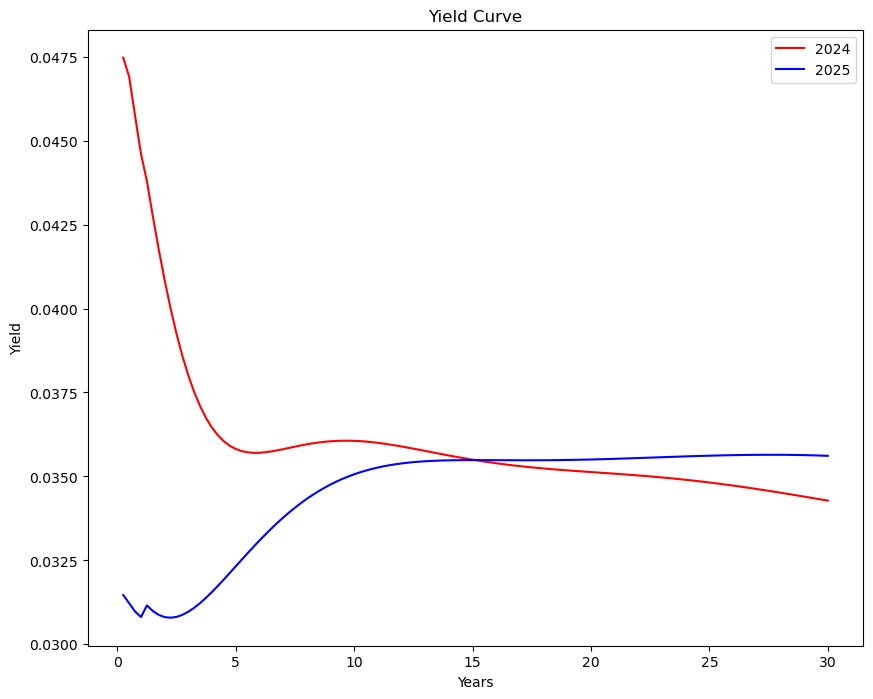

In [547]:
# plot the yield curve
plt.figure(figsize=(10, 8))

plt.plot(yield_curve['Date'], yield_curve['2024_data'], label='2024', color='red')
plt.plot(yield_curve['Date'], yield_curve['2025_data'], label='2025', color='blue')
plt.legend()

# axis labels
plt.xlabel('Years')
plt.ylabel('Yield')
plt.title('Yield Curve')
plt.show()

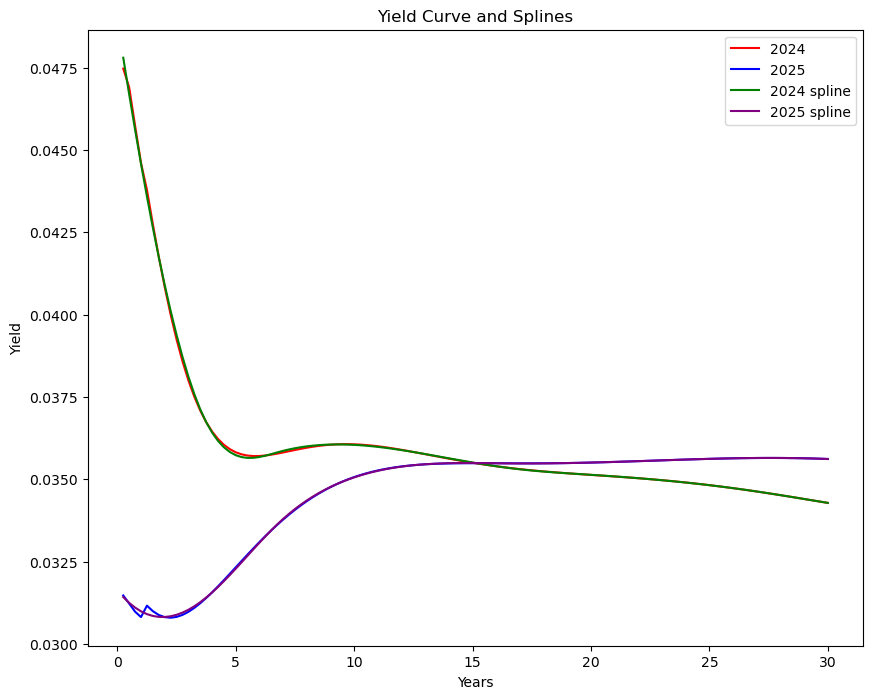

In [548]:
######### make model for splines to inteporlate the yield curve #########

# Define the positions of the knots (excluding the endpoints)
knots = np.linspace(yield_curve['Date'].min(), yield_curve['Date'].max(), 10)[1:-1]

# make the spline with specified knots
spline_2024 = LSQUnivariateSpline(yield_curve['Date'], yield_curve['2024_data'], t=knots, k=3)
spline_2025 = LSQUnivariateSpline(yield_curve['Date'], yield_curve['2025_data'], t=knots, k=3)

# make the plot
plt.figure(figsize=(10, 8))

plt.plot(yield_curve['Date'], yield_curve['2024_data'], label='2024', color='red')
plt.plot(yield_curve['Date'], yield_curve['2025_data'], label='2025', color='blue')

plt.plot(yield_curve['Date'], spline_2024(yield_curve['Date']), label='2024 spline', color='green')
plt.plot(yield_curve['Date'], spline_2025(yield_curve['Date']), label='2025 spline', color='purple')

plt.legend()

# axis labels
plt.xlabel('Years')
plt.ylabel('Yield')
plt.title('Yield Curve and Splines')
plt.show()

## Question 1

In [550]:
# given a date and a list of cash flow dates, find the number of years to the next cash flow date
def years_to_next_date(date, cash_flow_dates):

    days_to_next = [(cash_flow_date - date).days for cash_flow_date in cash_flow_dates if cash_flow_date > date]

    return min(days_to_next)/365

# fuction that given a start date, end date and frequency returns a list of dates that are the cash flow dates
def cashflow_dates(start_date, end_date, frequency):
    dates = []
    current_date = start_date

    while current_date > end_date:
        dates.append(current_date.date())
        current_date -= relativedelta(months=12/frequency)

    return dates

# given a bond with its maturity date, coupon frequency, issue date and interest rate and principal amount make a df of all the cash flows and the number of years away each one is
def cashflows_and_years(offering_date, maturity_date, frequency, today, principal, interest_rate):

    # generate cashflow dates
    cash_flow_dates = cashflow_dates(maturity_date, offering_date, frequency)
    
    # remove all cash flows that are before today
    cash_flow_dates = [date for date in cash_flow_dates if date > today]

    # find the years to the next coupon date
    years_to_next_coupon = years_to_next_date(today, cash_flow_dates)

    # get the years to maturity of each cash flow, the first one is the number of days from today until the next coupon then each coupon is 12/frequency more
    years = np.arange(len(cash_flow_dates) - 1, -1, -1) * 1/frequency + years_to_next_coupon

    # combine cash flow dates and years into a df
    cash_flows = pd.DataFrame({'Date': cash_flow_dates, 'Years': years})

    # add cashflow amounts
    cash_flows['Amount'] = principal * interest_rate/frequency

    # add the principal to the last cashflow
    cash_flows.loc[cash_flows.index[0], 'Amount'] += principal

    return cash_flows

# a function that given the cashflows and the spline model of the yields discounts each one to the present value
def present_value(cash_flows, spline, spread=0):

    cash_flows['Discounted'] = cash_flows['Amount']/((1 + spline(cash_flows['Years']) + spread)**cash_flows['Years'])

    return sum(cash_flows['Discounted'])

# make a function that combines everything
def bond_value(offering_date, maturity_date, frequency, today, principal, interest_rate, spline, spread):

    cashflows = cashflows_and_years(offering_date, maturity_date, frequency, today, principal, interest_rate)
    
    return present_value(cashflows, spline, spread)

# set day to 2024-05
date_2024 = datetime(2024, 5, 31).date()

# apply the bond_value function to the bonds df
bonds['2024_value'] = bonds.apply(lambda x: bond_value(x['OFFERING_DATE'], 
                                                  x['MATURITY'], 
                                                  x['INTEREST_FREQUENCY'], 
                                                  date_2024, 
                                                  x['PRINCIPAL_AMT'], 
                                                  x['COUPON']/100, 
                                                  spline_2024, 
                                                  x['TREASURY_SPREAD']/100/100), axis=1)

bonds['years_to_maturity'] = bonds.apply(lambda x : cashflows_and_years(x['OFFERING_DATE'],
                                                                       x['MATURITY'],
                                                                       x['INTEREST_FREQUENCY'],
                                                                       date_2024,
                                                                       x['PRINCIPAL_AMT'],
                                                                       x['COUPON']/100)['Years'][0], axis=1)

# the total price of all the bonds in the canadian market
canada_price_total_2024 = bonds['2024_value'].sum()

# the total price of all the bonds in the USA market
bonds['raw_reported_price'] = bonds['RPTD_LAST_PR'] * bonds['PRINCIPAL_AMT'] /100
usa_price_total_2024 = bonds['raw_reported_price'].sum()

# print the total prices
print('Total price of all the bonds in the Canadian market in 2024: ', round(canada_price_total_2024, 2))
print('Total price of all the bonds in the USA market in 2024: ', round(usa_price_total_2024, 2))

Total price of all the bonds in the Canadian market in 2024:  9739715.52
Total price of all the bonds in the USA market in 2024:  9417960.75


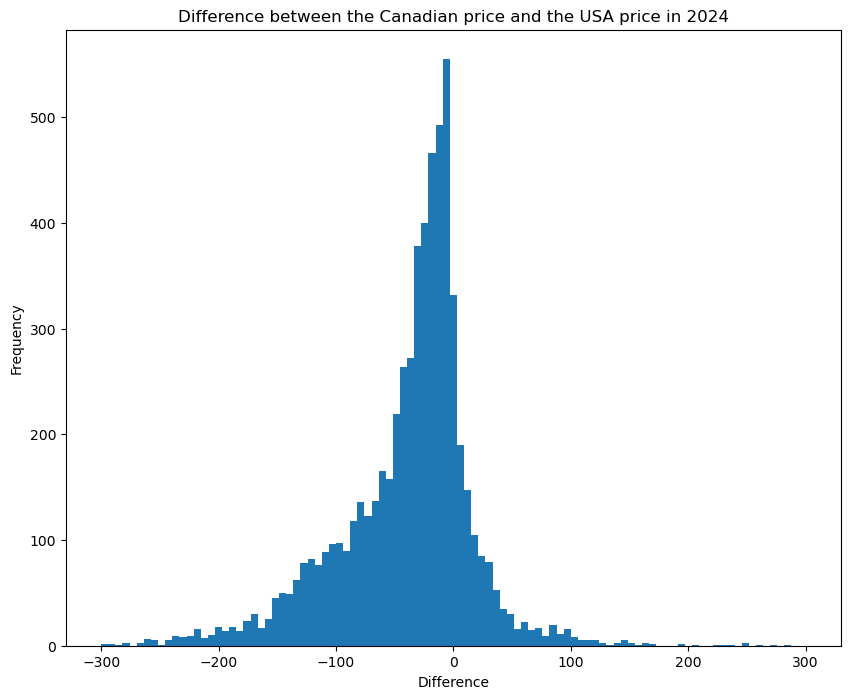

In [551]:
# take the difference between the usa prices and the canadian prices
bonds['difference'] = bonds['raw_reported_price'] - bonds['2024_value']

# histogram the differences only for a certain range
plt.figure(figsize=(10, 8)) 

plt.hist(bonds['difference'], bins=np.linspace(-300, 300, 100))

plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.title('Difference between the Canadian price and the USA price in 2024')
plt.show()

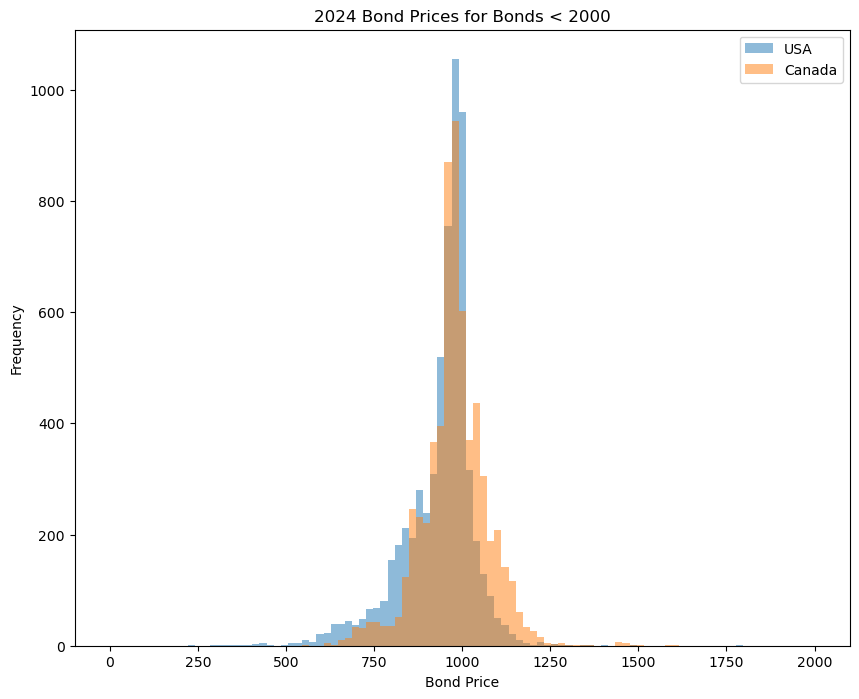

In [552]:
# overlay the two histograms
plt.figure(figsize=(10, 8))

plt.hist(bonds[bonds['raw_reported_price']<2000]['raw_reported_price'], bins=np.linspace(0, 2000, 100), alpha=0.5, label='USA')
plt.hist(bonds[bonds['2024_value']<2000]['2024_value'], bins=np.linspace(0, 2000, 100), alpha=0.5, label='Canada')

plt.xlabel('Bond Price')
plt.ylabel('Frequency')
plt.legend()
plt.title('2024 Bond Prices for Bonds < 2000')
plt.show()

## Question 2

In [554]:
# calculate 2025 bond prices

# set day to jan 13, 2025
date_2025 = datetime(2025, 1, 13).date()

# remove the bonds that have already matured
bonds_2025 = bonds[bonds['MATURITY'] > datetime(2025,1,13)].copy()

# apply the bond_value function to the bonds df
bonds_2025['2025_value'] = bonds_2025.apply(lambda x: bond_value(x['OFFERING_DATE'], 
                                                  x['MATURITY'], 
                                                  x['INTEREST_FREQUENCY'], 
                                                  date_2025, 
                                                  x['PRINCIPAL_AMT'], 
                                                  x['COUPON']/100, 
                                                  spline_2025, 
                                                  x['TREASURY_SPREAD']/100/100), axis=1)

bonds_2025['years_to_maturity'] = bonds_2025.apply(lambda x : cashflows_and_years(x['OFFERING_DATE'],
                                                                       x['MATURITY'],
                                                                       x['INTEREST_FREQUENCY'],
                                                                       date_2025,
                                                                       x['PRINCIPAL_AMT'],
                                                                       x['COUPON']/100)['Years'][0], axis=1)

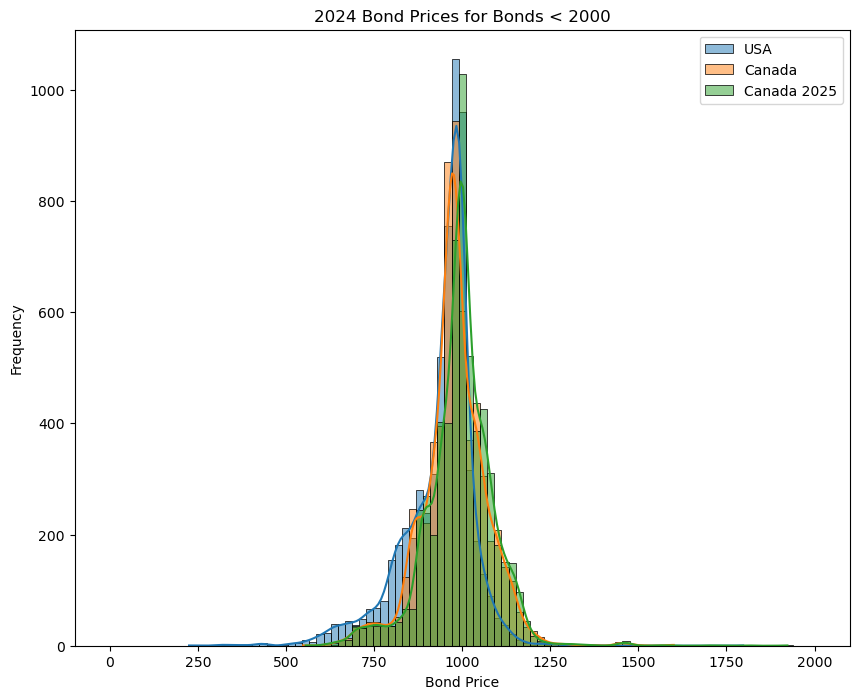

In [555]:
# overlay the histograms
plt.figure(figsize=(10, 8))

sns.histplot(bonds[bonds['raw_reported_price']<2000]['raw_reported_price'], 
         bins=np.linspace(0, 2000, 100), 
         alpha=0.5, 
         label='USA', 
         kde=True)

sns.histplot(bonds[bonds['2024_value']<2000]['2024_value'], 
         bins=np.linspace(0, 2000, 100), 
         alpha=0.5, 
         label='Canada',
         kde=True)


sns.histplot(bonds_2025[bonds_2025['2025_value']<2000]['2025_value'], 
         bins=np.linspace(0, 2000, 100), 
         alpha=0.5, 
         label='Canada 2025',
         kde=True)

plt.xlabel('Bond Price')
plt.ylabel('Frequency')
plt.legend()
plt.title('2024 Bond Prices for Bonds < 2000')
plt.show()

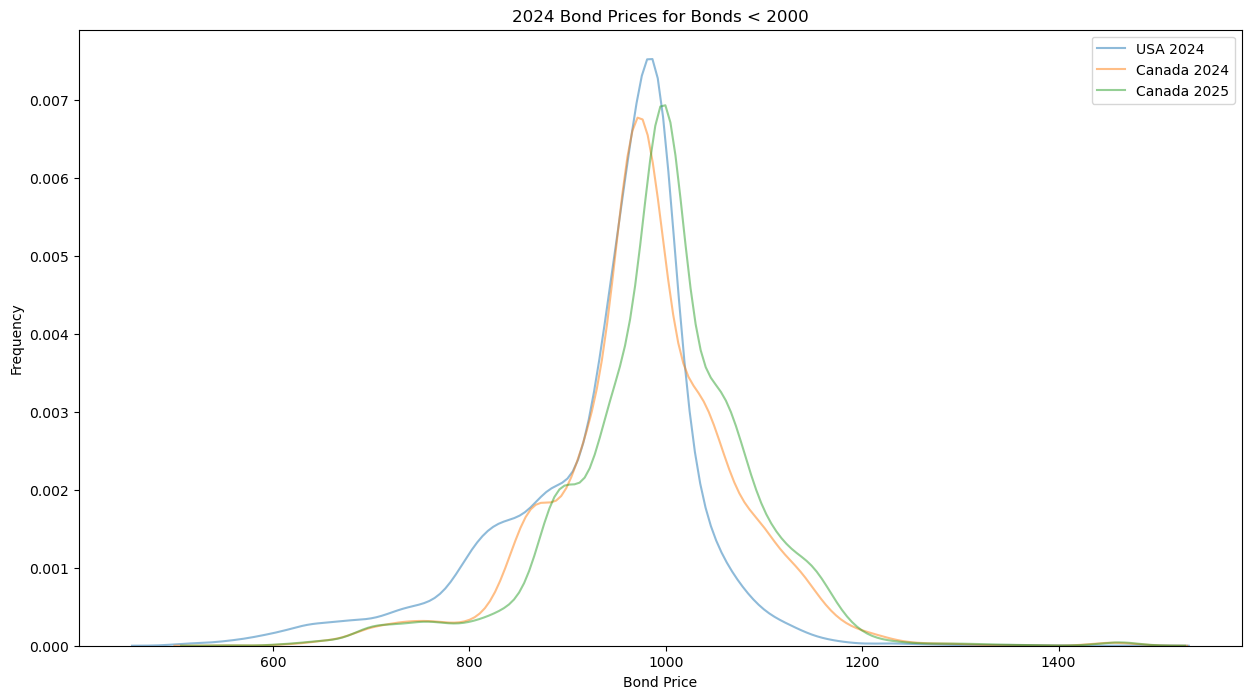

In [556]:
# overlay the kde plots
plt.figure(figsize=(15, 8))

sns.kdeplot(bonds[(bonds['raw_reported_price']<1500) & (bonds['raw_reported_price']>500)]['raw_reported_price'], 
         alpha=0.5, 
         label='USA 2024')

sns.kdeplot(bonds[(bonds['2024_value']<1500) & (bonds['2024_value']>500)]['2024_value'], 
         alpha=0.5, 
         label='Canada 2024')


sns.kdeplot(bonds_2025[(bonds_2025['2025_value']<1500) & (bonds_2025['2025_value']>500)]['2025_value'], 
         alpha=0.5, 
         label='Canada 2025')

plt.xlabel('Bond Price')
plt.ylabel('Frequency')
plt.legend()
plt.title('2024 Bond Prices for Bonds < 2000')
plt.show()

In [557]:
# Total value of bonds at 2025 after removing the ones that have matured
print('Total value of all the bonds in the USA market in 2024: ', round(bonds_2025['raw_reported_price'].sum(), 2))
print('Total value of all the bonds in the Canadian market in 2024: ', round(bonds_2025['2024_value'].sum(), 2))
print('Total value of all the bonds in the Canadian market in 2025: ', round(bonds_2025['2025_value'].sum(), 2))
# print that this is after removing the ones that have matured
print('The total value of the bonds in 2024 is after removing the ones that have matured before Jan 13, 2025')

Total value of all the bonds in the USA market in 2024:  9006235.1
Total value of all the bonds in the Canadian market in 2024:  9323774.73
Total value of all the bonds in the Canadian market in 2025:  9506016.55
The total value of the bonds in 2024 is after removing the ones that have matured before Jan 13, 2025


## Question 3

In [559]:
# Extract PD data from rating sheet
rating.set_index(rating.iloc[:, 0], inplace=True)
rating = rating.iloc[:, 1:]
pd_mean_series = rating.loc["Weighted long-term average"] / 100
pd_std_series = rating.loc["Standard deviation"] / 100

# Combine CCC, CC, and C ratings into one category
bonds_2025.loc[:, 'RATING'] = bonds_2025['RATING'].replace({'CCC':'CCC/C', 'CC':'CCC/C', 'C':'CCC/C'})

# Create a copy of bonds_2025 to avoid modifying the original DataFrame
bonds_cap = bonds_2025.copy()

# Map the PD mean values and the PD standard deviation to the bonds based on their rating
bonds_cap["PD_mean"] = bonds_cap["RATING"].map(pd_mean_series)
bonds_cap["PD_std"] = bonds_cap["RATING"].map(pd_std_series)

# Set LGD to 0.45 for bonds with SECURITY_LEVEL 'SEN' or 'SS'; otherwise, set LGD to 0.75
bonds_cap['LGD'] = np.where(bonds_cap['SECURITY_LEVEL'].isin(['SEN', 'SS']), 0.45, 0.75)

# -------------------------------------------
# Descriptive Statistics for LGD
# -------------------------------------------

lgd_stats = pd.Series(lgd).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
print("=== Descriptive Statistics for Loss Given Default (LGD) ===")
print(lgd_stats)

=== Descriptive Statistics for Loss Given Default (LGD) ===
count    6045.000000
mean        0.457196
std         0.045906
min         0.450000
5%          0.450000
25%         0.450000
50%         0.450000
75%         0.450000
95%         0.450000
99%         0.750000
max         0.750000
dtype: float64


In [560]:
# Monte Carlo Simulation Setup
# Define the number of simulations
num_simulations = 10000

# Extract necessary variables from bonds_cap as numpy arrays
pd_mean = bonds_cap['PD_mean'].values
pd_std = bonds_cap['PD_std'].values
lgd = bonds_cap['LGD'].values
ead = bonds_cap['PRINCIPAL_AMT'] * (bonds_cap['RPTD_LAST_PR'] / 100) .values # Exposure at Default (EAD)
maturity_years = bonds_cap['years_to_maturity'].values # Maturity years for each bond

# -------------------------------------------
# Descriptive Statistics for EAD
# -------------------------------------------

ead_stats = pd.Series(ead).describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

# Print summary statistics for EAD
print("\n=== Descriptive Statistics for Exposure at Default (EAD) ===")
print(ead_stats)

# Fix zero PD values to avoid log(0) error
pd_mean_fixed = np.where(pd_mean > 0, pd_mean, 1e-6)
pd_std_fixed = np.where(pd_std > 0, pd_std, 1e-6)

# Initialize arrays to store simulation results for capital requirements and expected losses
capitalreq_fixed = np.zeros(num_simulations)
expected_losses = np.zeros(num_simulations)

# Run Monte Carlo Simulation
for i in range(num_simulations):
    # Print progress every 1000 iterations
    if i % 1000 == 0:
        print(f"\nSimulation {i}/{num_simulations}")
    
    # create vector for random standard normal values
    z_values = np.random.normal(0, 1, len(bonds_cap))

    # create vector for sigma parameter for lognormal distribution
    sigma = np.sqrt(np.log(1 + (pd_std_fixed ** 2 / pd_mean_fixed ** 2)))

    # create vector for mu parameter for lognormal distribution
    mu = np.log(pd_mean_fixed) - (sigma ** 2 / 2)

    # generate uniform distribution with random values
    cumulative_probs = norm.cdf(z_values)

    # generate simulated PDs
    simulated_pds = lognorm.ppf(cumulative_probs, s=sigma, scale=np.exp(mu))

    # Clip simulated PDs to not exceed 1 and not be less than 0.0005 (according to Basel III)
    PD_clipped = np.clip(simulated_pds, 0.0005, 1 - 1e-9)

    # Calculate capital requirement for each simulation
    # Compute the correlation (R)
    R = 0.12 * (1 - np.exp(-50 * PD_clipped)) / (1 - np.exp(-50)) + \
        0.24 * (1 - (1 - np.exp(-50 * PD_clipped)) / (1 - np.exp(-50)))
    # Compute the Maturity adjustment (b) 
    b = (0.11852 - 0.05478 * np.log(PD_clipped)) ** 2
    # Compute the full maturity adjustment
    adjustment = (1 + (maturity_years - 2.5) * b) / (1 - 1.5 * b)
    # 4) The capital requirement (K) for each exposure is:
    K = (lgd * norm.cdf((norm.ppf(PD_clipped) + np.sqrt(R) * norm.ppf(0.999)) / np.sqrt(1 - R)) - PD_clipped * lgd)
    capitalreq_fixed[i] = np.sum(K * adjustment * ead)
    
    # Calculate Expected Loss (EL) for each simulation
    expected_losses[i] = np.sum(simulated_pds * lgd * ead)

# Results
capitalreq_summary_fixed = pd.DataFrame({
    "Capital Requirement": capitalreq_fixed,
    "Expected Loss": expected_losses
})

# Save results to CSV for further analysis
capitalreq_summary_fixed.to_csv("capital_requirement_summary.csv", index=False)


=== Descriptive Statistics for Exposure at Default (EAD) ===
count      6045.000000
mean       1489.865195
std       10415.399646
min         224.380000
5%          729.033160
25%         886.860000
50%         960.580000
75%         993.940000
95%        1061.712000
99%        1148.732800
max      219898.000000
Name: PRINCIPAL_AMT, dtype: float64

Simulation 0/10000

Simulation 1000/10000

Simulation 2000/10000

Simulation 3000/10000

Simulation 4000/10000

Simulation 5000/10000

Simulation 6000/10000

Simulation 7000/10000

Simulation 8000/10000

Simulation 9000/10000


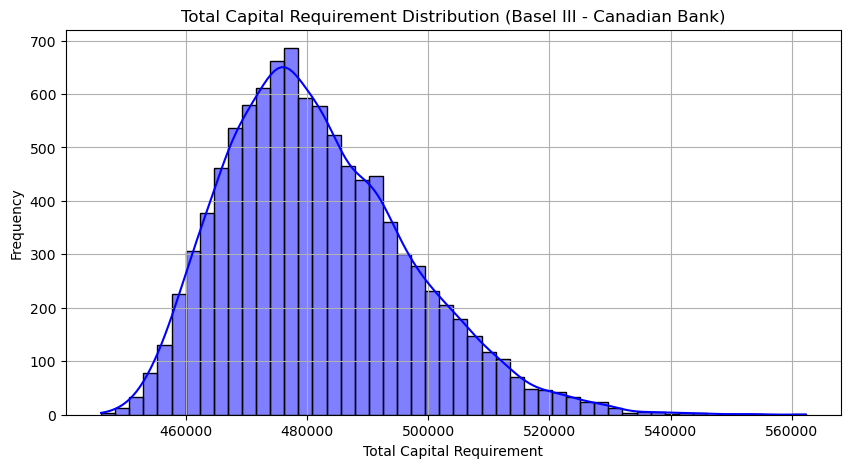

In [561]:
# -------------------------------------------
# Generate Histograms for Required Outputs
# -------------------------------------------

# Histogram for Total Capital Requirement Distribution (Basel III)
plt.figure(figsize=(10, 5))
sns.histplot(capitalreq_fixed, bins=50, kde=True, color='blue')
plt.xlabel("Total Capital Requirement")
plt.ylabel("Frequency")
plt.title("Total Capital Requirement Distribution (Basel III - Canadian Bank)")
plt.grid(True)
plt.show()

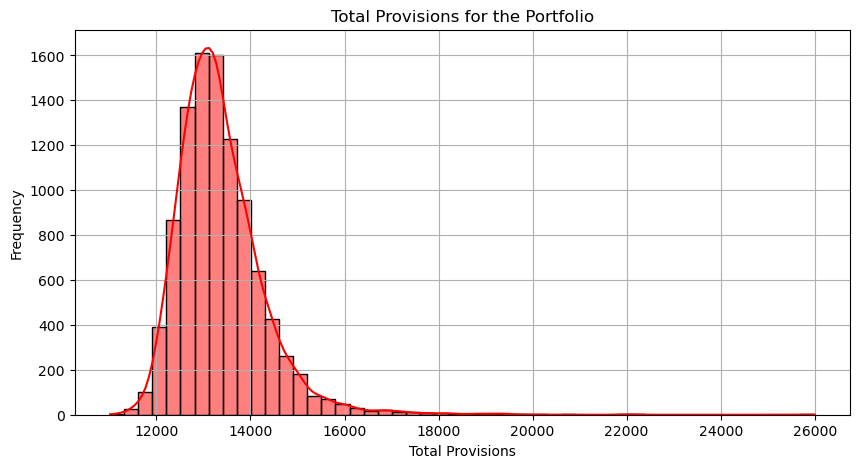

In [562]:
# -------------------------------------------
# Generate Histograms for Required Outputs
# -------------------------------------------

# Histogram for Total Provisions for the Portfolio
plt.figure(figsize=(10, 5))
sns.histplot(expected_losses, bins=50, kde=True, color='red')
plt.xlabel("Total Provisions")
plt.ylabel("Frequency")
plt.title("Total Provisions for the Portfolio")
plt.grid(True)
plt.show()

In [563]:
# -------------------------------------------
# Descriptive Statistics for Capital Requirements and Expected Losses
# -------------------------------------------

print(capitalreq_summary_fixed.describe())

       Capital Requirement  Expected Loss
count         10000.000000   10000.000000
mean         481801.672200   13361.904656
std           15277.189073     923.295990
min          446053.150533   11013.194461
25%          470657.122094   12760.531421
50%          479764.220787   13224.246175
75%          491241.486558   13792.653346
max          562264.965290   25995.259793
